In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GraphConv
from torch_geometric.nn.norm import BatchNorm
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import itertools
from math import radians, sin, cos, sqrt, atan2
import numpy as np
from torch.optim.swa_utils import AveragedModel, SWALR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.pyplot as plt

/mnt/HDD/RyanFolder/projects/Weather-Predition-Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <div align="center">**ZE EPIC DATA**</div>

In [3]:
# Directory containing the CSV files
directory = '../processed-final-data-2'

# Dictionary to store the dataframes
dataframes = {}

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Extract the file name without extension and convert it to int
        key = int(os.path.splitext(filename)[0])
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes[key] = df


# Print the dictionary keys to verify
print(dataframes.keys())

dict_keys([72790024141, 72785524114, 72789094197, 72793024233, 72785794129, 72788594266, 72797624217, 72785024157, 72797094240, 72798594276, 72792424223, 72792894263, 72781024243, 72781524237, 72788324220, 72698824219, 72793894274, 74206024207, 72782724110, 72793724222, 72792594227, 72782594239, 72794504205, 72792394225, 72784524163, 72792024227, 72785694176])


In [4]:
# Dictionaries to store the training and testing dataframes
train_dataframes = {}
test_dataframes = {}

# Split each dataframe into training and testing sets
for key, df in dataframes.items():
    train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
    train_dataframes[key] = train_df
    test_dataframes[key] = test_df
    # Check if the maximum index of the training set is less than the minimum index of the testing set
    if train_df.index.max() < test_df.index.min():
        print(f"{key}: Sequential split verified.")
    else:
        print(f"{key}: Sequential split NOT verified.")

# Print the keys of the training and testing dictionaries to verify
print(train_dataframes.keys())
print(test_dataframes.keys())

72790024141: Sequential split verified.
72785524114: Sequential split verified.
72789094197: Sequential split verified.
72793024233: Sequential split verified.
72785794129: Sequential split verified.
72788594266: Sequential split verified.
72797624217: Sequential split verified.
72785024157: Sequential split verified.
72797094240: Sequential split verified.
72798594276: Sequential split verified.
72792424223: Sequential split verified.
72792894263: Sequential split verified.
72781024243: Sequential split verified.
72781524237: Sequential split verified.
72788324220: Sequential split verified.
72698824219: Sequential split verified.
72793894274: Sequential split verified.
74206024207: Sequential split verified.
72782724110: Sequential split verified.
72793724222: Sequential split verified.
72792594227: Sequential split verified.
72782594239: Sequential split verified.
72794504205: Sequential split verified.
72792394225: Sequential split verified.
72784524163: Sequential split verified.


In [5]:
def create_node_features_sequences(dataframes):
    # Create a list to store the node features for each time step for input and desired output
    node_features_sequence_input = []
    node_features_sequence_output = []

    # Iterate over the rows of the dataframes (assuming all dataframes have the same number of rows)
    for i in range(len(next(iter(dataframes.values())))):
        if i == len(next(iter(dataframes.values()))) - 1:
            break
        # Create a list to store the features of all nodes at the current time step for input
        node_features_input = []
        # Create a list to store the features of all nodes at the next time step for output
        node_features_output = []

        # Iterate over each dataframe and extract the features at the current row for input
        # and the next row for output
        for key, df in dataframes.items():
            node_features_input.append((df.iloc[i].values - df.iloc[i].mean()) / df.iloc[i].std())
            node_features_output.append(df.iloc[i + 1].values)

        # Stack the features of all nodes to create a 2D array (num_nodes, num_features)
        node_features_sequence_input.append(np.stack(node_features_input))
        node_features_sequence_output.append(np.stack(node_features_output))

    # Convert the lists to numpy arrays (time_steps, num_nodes, num_features)
    node_features_sequence_input = np.array(node_features_sequence_input)
    node_features_sequence_output = np.array(node_features_sequence_output)

    # Convert the numpy arrays to torch tensors
    node_features_sequence_input = torch.tensor(node_features_sequence_input, dtype=torch.float)
    node_features_sequence_output = torch.tensor(node_features_sequence_output, dtype=torch.float)

    return node_features_sequence_input, node_features_sequence_output

# Call the function and print the shapes of the resulting tensors
node_features_sequence_input_train, node_features_sequence_output_train = create_node_features_sequences(train_dataframes)
node_features_sequence_input_test, node_features_sequence_output_test = create_node_features_sequences(test_dataframes)
print(node_features_sequence_input_train.shape)
print(node_features_sequence_output_test.shape)

torch.Size([1408, 27, 70])
torch.Size([352, 27, 70])


In [6]:
# Calculate mean and standard deviation of the training data
mean = node_features_sequence_input_train.mean(dim=(0, 1), keepdim=True)
std = node_features_sequence_input_train.std(dim=(0, 1), keepdim=True)

# Normalize the training and testing data
# node_features_sequence_input_train = (node_features_sequence_input_train - mean) / std
# node_features_sequence_input_test = (node_features_sequence_input_test - mean) / std

# Print the mean and standard deviation to verify
print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor([[[ 2.5068, -0.0083,  0.1616,  1.8645,  1.7890,  4.7494, -0.3193,
           2.9336,  1.8637, -0.3198,  3.3552, -0.2026, -0.3196, -0.3129,
          -0.3196, -0.3186, -0.3197, -0.3197, -0.3197, -0.3197, -0.3196,
          -0.3197, -0.3197, -0.3197, -0.3026, -0.2830, -0.3197, -0.3197,
          -0.3197, -0.3197, -0.3193, -0.3129, -0.3196, -0.3197, -0.3195,
          -0.3192, -0.3195, -0.3197, -0.3197, -0.3197, -0.3185, -0.3197,
          -0.3194, -0.3196, -0.3196, -0.3140, -0.3194, -0.3197, -0.3188,
          -0.3197, -0.2848, -0.3197, -0.3191, -0.3197, -0.3196, -0.3193,
          -0.3197, -0.3184, -0.2834, -0.3197, -0.3197, -0.3140, -0.3176,
          -0.3193, -0.3185, -0.3196, -0.3197, -0.3194, -0.3126, -0.3197]]])
Standard Deviation: tensor([[[0.5516, 0.1048, 0.3027, 0.2799, 0.2542, 1.4446, 0.0145, 0.6318,
          0.2789, 0.0144, 0.9440, 0.1545, 0.0146, 0.0244, 0.0147, 0.0165,
          0.0143, 0.0144, 0.0143, 0.0144, 0.0146, 0.0144, 0.0146, 0.0144,
          0.0375, 0

# <div align="center">**ZE EPIC EDGE DATA**</div>

In [7]:
# Import the location-datamap.csv file as a dataframe
location_datamap_df = pd.read_csv('../location-datamap.csv')

# Print the first few rows of the dataframe to verify
print(location_datamap_df.head())

        STATION  LONGITUDE  LATITUDE  ELEVATION
0  7.279002e+10 -119.51551  47.30777      382.1
1  7.278552e+10 -117.65000  47.63333      750.1
2  7.278909e+10 -119.52091  48.46113      397.4
3  7.279302e+10 -122.31442  47.44467      112.5
4  7.278579e+10 -117.11581  46.74376      775.7


In [8]:
def haversine_distance(lat1, lon1, lat2, lon2, el1=0, el2=0):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    # Elevation difference
    height = el2 - el1

    # Calculate the total distance considering elevation
    total_distance = sqrt(distance**2 + height**2)

    return total_distance

In [9]:
# Create a dictionary to store the distances between nodes
distances = {}

# Define the number of nodes
num_nodes = len(dataframes)

# Iterate over each pair of nodes
for i, j in itertools.combinations(range(num_nodes), 2):
    # Get the station IDs for the nodes
    station_i = list(dataframes.keys())[i]
    station_j = list(dataframes.keys())[j]
    
    # Get the location data for the stations
    location_i = location_datamap_df[location_datamap_df['STATION'] == station_i].iloc[0]
    location_j = location_datamap_df[location_datamap_df['STATION'] == station_j].iloc[0]
    
    # Calculate the distance between the stations
    distance = haversine_distance(location_i['LATITUDE'], location_i['LONGITUDE'], location_j['LATITUDE'], location_j['LONGITUDE'], location_i['ELEVATION'], location_j['ELEVATION'])
    
    # Store the distance in the dictionary
    distances[(i, j)] = distance

# Print the distances to verify
print(distances)

{(0, 1): 395.4679457314314, (0, 2): 129.15783117310457, (0, 3): 342.5330553210191, (0, 4): 438.10430559873856, (0, 5): 432.0504921333856, (0, 6): 437.11321302131137, (0, 7): 369.0087247919059, (0, 8): 503.7031148557305, (0, 9): 455.6811328123654, (0, 10): 474.59654599988056, (0, 11): 348.0950737502581, (0, 12): 128.6980383337319, (0, 13): 835.9738346074198, (0, 14): 171.59537540199554, (0, 15): 384.56540064951065, (0, 16): 373.58764051749137, (0, 17): 362.1843030623904, (0, 18): 32.53657446575969, (0, 19): 306.4908073667999, (0, 20): 404.50991220772727, (0, 21): 52.81240627430448, (0, 22): 404.8085057270694, (0, 23): 505.4288197147213, (0, 24): 286.0836462058196, (0, 25): 412.6227567328569, (0, 26): 272.19719043646785, (1, 2): 390.14029117618804, (1, 3): 727.6917541369755, (1, 4): 109.85904921372176, (1, 5): 798.995937782049, (1, 6): 802.4581375032445, (1, 7): 33.690956835057186, (1, 8): 865.1737430163511, (1, 9): 825.6499844120128, (1, 10): 860.6728795779842, (1, 11): 724.996392306694

In [10]:
# Extract the distance values from the dictionary
distance_values = np.array(list(distances.values()))

# Perform Min-Max normalization
min_distance = distance_values.min()
max_distance = distance_values.max()
normalized_distances = (distance_values - min_distance) / (max_distance - min_distance)

# Update the distances dictionary with normalized values
normalized_distances_dict = {key: normalized_distances[i] for i, key in enumerate(distances.keys())}

# Print the normalized distances to verify
print(normalized_distances_dict)

{(0, 1): 0.314567998140773, (0, 2): 0.09280158354609237, (0, 3): 0.2704871307176606, (0, 4): 0.35007289315695667, (0, 5): 0.34503165576699535, (0, 6): 0.349247573218238, (0, 7): 0.2925344130835223, (0, 8): 0.40469948049003845, (0, 9): 0.3647097760165542, (0, 10): 0.380461349591329, (0, 11): 0.27511883194691195, (0, 12): 0.0924186968141592, (0, 13): 0.6813937634553494, (0, 14): 0.1281409173278857, (0, 15): 0.3054890401868689, (0, 16): 0.2963474478414338, (0, 17): 0.28685146130699407, (0, 18): 0.012341441395062182, (0, 19): 0.2404733998610767, (0, 20): 0.32209758254900717, (0, 21): 0.029225886548649996, (0, 22): 0.3223462325648563, (0, 23): 0.4061365396113629, (0, 24): 0.2234795918330484, (0, 25): 0.32885345228187846, (0, 26): 0.21191581960267647, (1, 2): 0.31013146049414686, (1, 3): 0.5912232162697533, (1, 4): 0.0767307644250279, (1, 5): 0.6506008827124798, (1, 6): 0.6534839861952507, (1, 7): 0.013302738864123758, (1, 8): 0.7057096216985912, (1, 9): 0.672796706424883, (1, 10): 0.7019615

In [11]:
# Create edge index and edge attributes from distances dictionary
edge_index = []
edge_attr = []

for (i, j), distance in distances.items():
    edge_index.append([i, j])
    edge_index.append([j, i])  # Assuming undirected graph
    edge_attr.append([distance])
    edge_attr.append([distance])  # Assuming undirected graph

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

# <div align="center">**ZE EPIC GPU IMPORT**</div>

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Move data to device
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

# <div align="center">**ZE EPIC BATCHING**</div>

In [14]:
batch_size = node_features_sequence_input_train.shape[0] //2 # Adjust this value based on your GPU memory capacity
# Calculate the number of full batches
num_full_batches_train = (node_features_sequence_input_train.size(0) // batch_size) * batch_size

# Trim the input and output tensors to have a size divisible by the batch size
trimmed_input_train = node_features_sequence_input_train[:num_full_batches_train]
trimmed_output_train = node_features_sequence_output_train[:num_full_batches_train]

# Create batches of data
batched_input_train = trimmed_input_train.view(-1, batch_size, trimmed_input_train.size(1), trimmed_input_train.size(2))
batched_output_train = trimmed_output_train.view(-1, batch_size, trimmed_output_train.size(1), trimmed_output_train.size(2))

# Adjust the number of batches
num_batches_train = batched_input_train.size(0)

# Print the batch size and number of full batches to verify
print("Batch size:", batch_size)
print("Number of full batches:", num_full_batches_train)

print("Batched input train dimensionality:", batched_input_train.shape)
print("Batched output train dimensionality:", batched_output_train.shape)


Batch size: 704
Number of full batches: 1408
Batched input train dimensionality: torch.Size([2, 704, 27, 70])
Batched output train dimensionality: torch.Size([2, 704, 27, 70])


In [15]:
batch_size = node_features_sequence_input_test.shape[0] // 4# Adjust this value based on your GPU memory capacity
# Calculate the number of full batches
num_full_batches_test = (node_features_sequence_input_test.size(0) // batch_size) * batch_size

# Trim the input and output tensors to have a size divisible by the batch size
trimmed_input_test = node_features_sequence_input_test[:num_full_batches_test]
trimmed_output_test = node_features_sequence_output_test[:num_full_batches_test]

# Create batches of data
batched_input_test = trimmed_input_test.view(-1, batch_size, trimmed_input_test.size(1), trimmed_input_test.size(2))
batched_output_test = trimmed_output_test.view(-1, batch_size, trimmed_output_test.size(1), trimmed_output_test.size(2))

# Adjust the number of batches
num_batches_test = batched_input_test.size(0)
print("Batch size:", batch_size)
print("Number of full batches:", num_full_batches_train)

print("Batched input test dimensionality:", batched_input_test.shape)
print("Batched output test dimensionality:", batched_output_test.shape)

Batch size: 88
Number of full batches: 1408
Batched input test dimensionality: torch.Size([4, 88, 27, 70])
Batched output test dimensionality: torch.Size([4, 88, 27, 70])


# <div align="center">**ZE EPIC MODEL**</div>

In [ ]:
class GNNWithTransformer(torch.nn.Module):
    def __init__(self, in_channels, edge_in_channels, hidden_channels, out_channels, num_transformer_layers, lstm_hidden_size, lstm_num_layers):
        super(GNNWithTransformer, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, edge_dim=edge_in_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.batch_norm1 = BatchNorm(hidden_channels)
        self.batch_norm2 = BatchNorm(hidden_channels)
        self.batch_norm3 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

        # Transformer encoder layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_channels, nhead=16),
            num_layers=num_transformer_layers
        )
        
        self.output_layer = torch.nn.Linear(hidden_channels, out_channels)
    def gnn_forward(self, x, edge_index, edge_attr):
        # Spatial processing for a single time step
        edge_weight = 1.0 / edge_attr

        x1 = self.conv1(x, edge_index, edge_weight)
        x1 = F.relu(x1)
        x1 = self.dropout(x1)

        x2 = self.conv2(x1, edge_index)
        x2 = F.relu(x2)
        x2 = self.dropout(x2)

        x3 = self.conv3(x2, edge_index, edge_weight)
        x3 = F.relu(x3)
        x3 = self.dropout(x3)

        x = x1 + x2 + x3  # Residual connection
        return x  # Shape: [num_nodes, hidden_channels]
    
    def forward(self, x, edge_index, edge_attr):
        # Calculate edge weights as the inverse of edge attributes
        edge_weight = 1.0 / edge_attr

        # Apply the first GAT convolution with edge weights
        x1 = self.conv1(x, edge_index, edge_weight)
        x1 = self.batch_norm1(x1)
        x1 = F.relu(x1)
        x1 = self.dropout(x1)
        
        # Apply the Graph convolution
        x2 = self.conv2(x1, edge_index)
        x2 = self.batch_norm2(x2)
        x2 = F.relu(x2)
        x2 = self.dropout(x2)
        
        # Apply the GCN convolution
        x3 = self.conv3(x2, edge_index, edge_weight)
        x3 = self.batch_norm3(x3)
        x3 = F.relu(x3)
        x3 = self.dropout(x3)
        
        # Add residual connections
        x = x1 + x2 + x3 
        
        # # Prepare data for Transformer
        # Reshape x to include the batch dimension
        # Assuming x has shape [batch_size * num_nodes, hidden_channels]
        num_nodes = x.size(0) // batch_size
        x = x.view(batch_size, num_nodes, -1)  # Shape: [batch_size, num_nodes, hidden_channels]

        # Permute dimensions to match transformer's expected input
        x = x.permute(1, 0, 2)  # Shape: [num_nodes, batch_size, hidden_channels]

        # Apply transformer encoder
        x = self.transformer_encoder(x)

        # Permute back to original dimensions
        x = x.permute(1, 0, 2)  # Shape: [batch_size, num_nodes, hidden_channels]

        # Flatten the batch and node dimensions
        x = x.reshape(-1, x.size(2))  # Shape: [batch_size * num_nodes, hidden_channels]
        
        # Apply the output layer
        x = self.output_layer(x)
        
        return x


# <div align="center">**ZE EPIC MODEL SETUP**</div>

In [16]:
# Define the parameters
in_channels = node_features_sequence_input_train.shape[2]
out_channels = in_channels  
edge_in_channels = 1
hidden_channels = 512
num_transformer_layers = 4
lstm_hidden_size = 256
lstm_num_layers = 1

print("Number of input channels:", in_channels)
print("Number of output channels:", out_channels)
print("Number of hidden channels:", hidden_channels)
print("Number of transformer layers:", num_transformer_layers)
print("LSTM hidden size:", lstm_hidden_size)
print("LSTM number of layers:", lstm_num_layers)

model = GNNWithTransformer(in_channels, edge_in_channels, hidden_channels, out_channels, num_transformer_layers, lstm_hidden_size, lstm_num_layers).to(device)

Number of input channels: 70
Number of output channels: 70
Number of hidden channels: 512
Number of transformer layers: 4
LSTM hidden size: 256
LSTM number of layers: 1


/mnt/HDD/RyanFolder/projects/Weather-Predition-Project/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [17]:
# Define the parameters
num_epochs = 500  # Adjust the number of epochs as needed
learning_rate = 0.01
scheduler_mode = 'min'
scheduler_factor = 0.8
scheduler_patience = 10

#Print all parameter 
print("Number of epochs:", num_epochs)
print("Learning rate:", learning_rate)
print("Scheduler mode:", scheduler_mode)
print("Scheduler factor:", scheduler_factor)
print("Scheduler patience:", scheduler_patience)
# print("Number of warmup steps:", num_warmpup_steps)
# print("Number of training steps:", num_training_steps)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=scheduler_mode, factor=scheduler_factor, patience=scheduler_patience, verbose=True,min_lr=1e-5)
loss_fn = torch.nn.MSELoss()

Number of epochs: 500
Learning rate: 0.01
Scheduler mode: min
Scheduler factor: 0.8
Scheduler patience: 10


/mnt/HDD/RyanFolder/projects/Weather-Predition-Project/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# <div align="center">**ZE EPIC MODEL TRAIN**</div>

In [18]:
# Training loop
epoch_losses = []
epoch_maes = []

# Set the model to training mode
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    total_mae = 0
    
    optimizer.zero_grad()
    
    for b in range(num_batches_train):
        # Get the batched node features and desired output
        node_features_batch = batched_input_train[b].to(device)
        desired_output_batch = batched_output_train[b].to(device)
        
        # Reshape node_features_batch to match the expected input shape for the model
        node_features_batch = node_features_batch.view(-1, node_features_batch.size(2))
        
        # Forward pass with batch_size parameter
        model_output_batch = model(node_features_batch, edge_index, edge_attr, batch_size=batched_input_train.size(1))
        
        # Reshape model_output_batch back to the original shape
        model_output_batch = model_output_batch.view(batched_input_train.size(1), -1, model_output_batch.size(1))
        
        loss = loss_fn(model_output_batch, desired_output_batch)
        
        # Backward pass
        loss.backward()
        
        # Update the optimizer
        optimizer.step()
        optimizer.zero_grad()
        
        # Compute MAE for debugging
        mae = torch.mean(torch.abs(model_output_batch - desired_output_batch))
        
        total_loss += loss.item()
        total_mae += mae.item()

    average_loss = total_loss / num_batches_train
    average_mae = total_mae / num_batches_train
    epoch_losses.append(average_loss)
    epoch_maes.append(average_mae)

    scheduler.step(average_loss)

    current_lr = optimizer.param_groups[0]['lr']
    current_patience = scheduler.num_bad_epochs
    print(f"Epoch {epoch+1}, Average Loss: {average_loss}, Average MAE: {average_mae}, Learning Rate: {current_lr}, Current Patience: {current_patience}")
    torch.cuda.empty_cache()



Epoch 1, Average Loss: 197.14166259765625, Average MAE: 4.65074348449707, Learning Rate: 0.01, Current Patience: 0
Epoch 2, Average Loss: 136.25873947143555, Average MAE: 5.1172027587890625, Learning Rate: 0.01, Current Patience: 0
Epoch 3, Average Loss: 85.08840560913086, Average MAE: 3.712502121925354, Learning Rate: 0.01, Current Patience: 0
Epoch 4, Average Loss: 51.335208892822266, Average MAE: 2.6086992025375366, Learning Rate: 0.01, Current Patience: 0
Epoch 5, Average Loss: 31.58663272857666, Average MAE: 1.883758783340454, Learning Rate: 0.01, Current Patience: 0
Epoch 6, Average Loss: 24.36920166015625, Average MAE: 1.882710874080658, Learning Rate: 0.01, Current Patience: 0
Epoch 7, Average Loss: 23.035754203796387, Average MAE: 1.8495389223098755, Learning Rate: 0.01, Current Patience: 0
Epoch 8, Average Loss: 19.67526626586914, Average MAE: 1.6259208917617798, Learning Rate: 0.01, Current Patience: 0
Epoch 9, Average Loss: 14.924764156341553, Average MAE: 1.279853940010070

KeyboardInterrupt: 

# <div align="center">**ZE EPIC GRAPHS**</div>

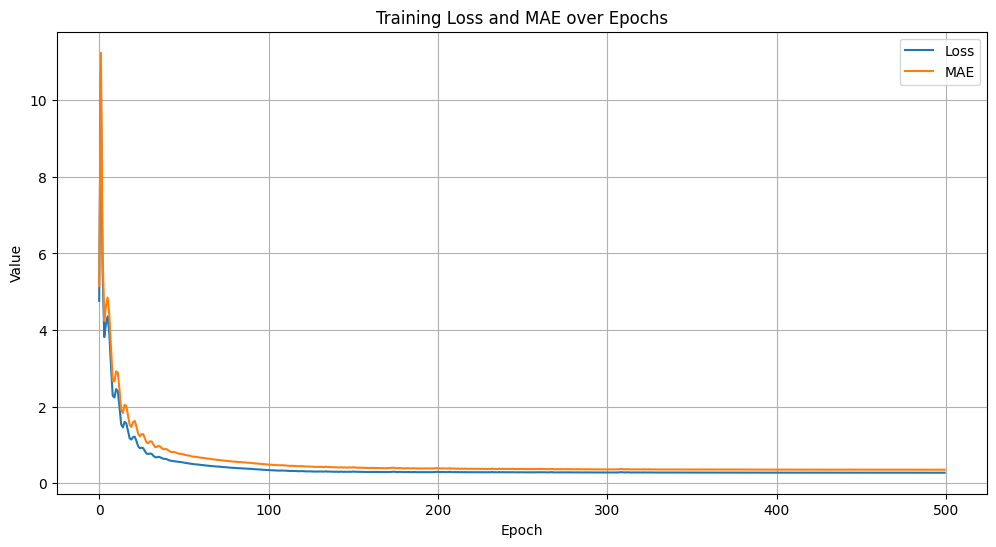

In [ ]:
# Plot the epoch losses and MAEs
plt.figure(figsize=(12, 6))
plt.plot(epoch_losses, label='Loss')
plt.plot(epoch_maes, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and MAE over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
# Initialize lists to store losses and MAEs
test_losses = []
test_maes = []

test_losses_per_matrix = []
test_maes_per_matrix = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for b in range(num_batches_test):
        # Get the batched node features and desired output
        node_features_batch = batched_input_test[b].to(device)
        desired_output_batch = batched_output_test[b].to(device)
        
        # Reshape node_features_batch to match the expected input shape for the model
        node_features_batch = node_features_batch.view(-1, node_features_batch.size(2))
        
        # Get the model output
        model_output_batch = model(node_features_batch, edge_index, edge_attr)
        
        # Reshape model_output_batch back to the original shape
        model_output_batch = model_output_batch.view(batched_input_test.size(1), -1, model_output_batch.size(1))
        
        # Compute loss and MAE
        loss = loss_fn(model_output_batch, desired_output_batch)
        mae = torch.mean(torch.abs(model_output_batch - desired_output_batch))
        
        # Store the loss and MAE
        test_losses.append(loss.item())
        test_maes.append(mae.item())

        print(f"Batch {b+1} - Model Output and Desired Output Matrices:")
        model_output_np = model_output_batch.cpu().numpy()
        desired_output_np = desired_output_batch.cpu().numpy()

        for i in range(model_output_np.shape[0]):
            print()
            print(f"Model Output Matrix {i+1}:")
            np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})
            print(model_output_np[i])
            print(f"Desired Output Matrix {i+1}:")
            print(desired_output_np[i])
            
            # Calculate loss and MAE for each matrix
            matrix_loss = loss_fn(torch.tensor(model_output_np[i], device=device), torch.tensor(desired_output_np[i], device=device))
            matrix_mae = torch.mean(torch.abs(torch.tensor(model_output_np[i], device=device) - torch.tensor(desired_output_np[i], device=device)))
            print(f"Loss for Matrix {i+1}: {matrix_loss.item()}")
            print(f"MAE for Matrix {i+1}: {matrix_mae.item()}")

            test_losses_per_matrix.append(matrix_loss.item())
            test_maes_per_matrix.append(matrix_mae.item())

# Print the average loss and MAE for the test set
average_test_loss = sum(test_losses) / len(test_losses)
average_test_mae = sum(test_maes) / len(test_maes)
print(f"Average Test Loss: {average_test_loss}, Average Test MAE: {average_test_mae}")

Batch 1 - Model Output and Desired Output Matrices:

Model Output Matrix 1:
[[54.4242 6.9925 6.4796 ... -0.0554 0.1486 -0.0172]
 [54.4043 6.9904 6.4780 ... -0.0554 0.1484 -0.0172]
 [54.3869 6.9885 6.4766 ... -0.0554 0.1482 -0.0172]
 ...
 [54.3790 6.9877 6.4760 ... -0.0554 0.1481 -0.0172]
 [54.4347 6.9936 6.4804 ... -0.0555 0.1487 -0.0172]
 [54.3891 6.9887 6.4768 ... -0.0554 0.1482 -0.0172]]
Desired Output Matrix 1:
[[34.3200 3.8750 11.4000 ... 0.0000 0.0000 0.0000]
 [21.0000 4.5000 18.6571 ... 0.0000 0.0000 0.0000]
 [35.4839 4.1250 12.0000 ... 0.0000 0.0000 0.0000]
 ...
 [37.2800 4.2500 16.8800 ... 0.0000 0.0000 0.0000]
 [46.0164 3.5000 13.7213 ... 0.0000 0.0000 0.0000]
 [35.4800 5.0000 11.5600 ... 0.0000 0.0000 0.0000]]
Loss for Matrix 1: 1.9564052820205688
MAE for Matrix 1: 2.059877634048462

Model Output Matrix 2:
[[32.2965 4.2761 7.7051 ... 0.0048 0.0021 0.0008]
 [22.9552 4.0313 11.1650 ... -0.0044 -0.0578 0.0018]
 [33.5017 4.2349 8.2049 ... 0.0042 0.0042 0.0007]
 ...
 [36.4144 4.0

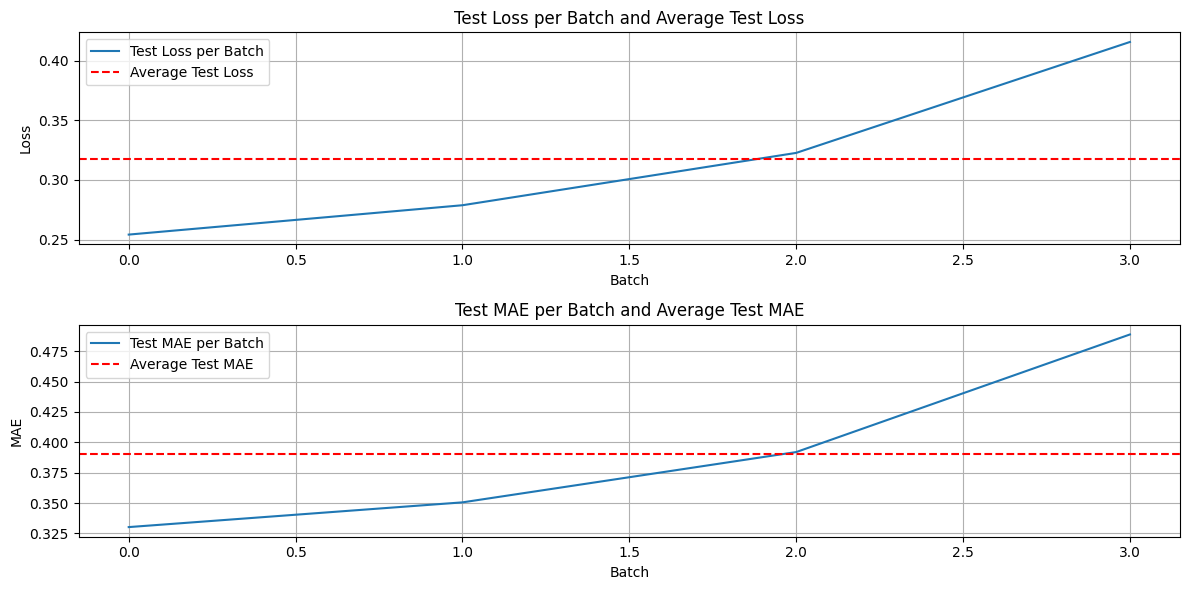

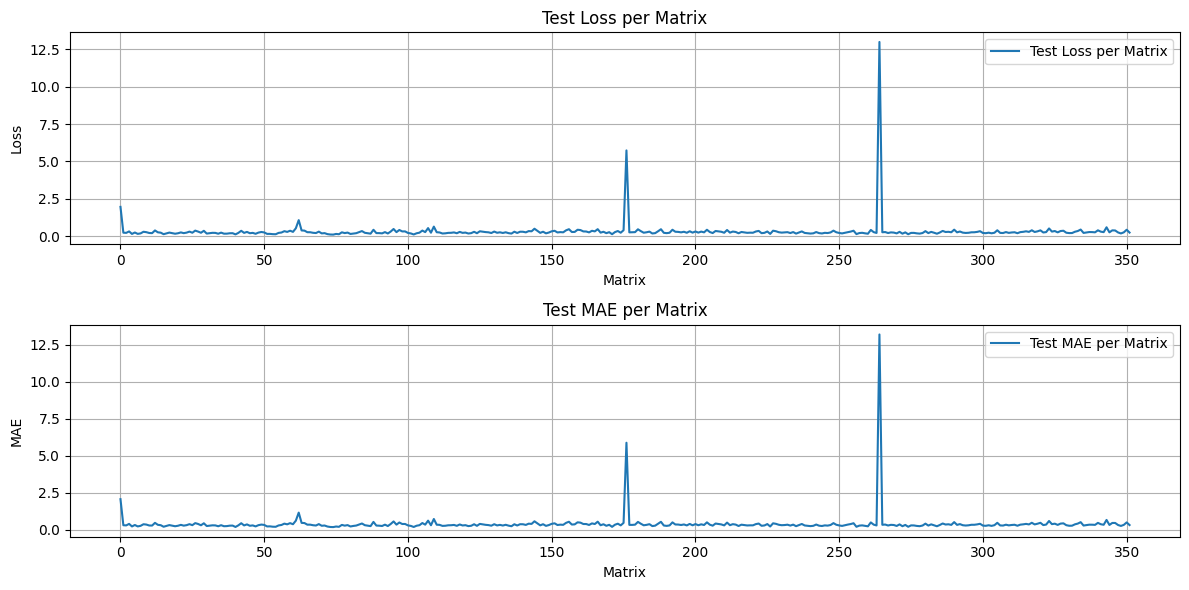

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(test_losses, label='Test Loss per Batch')
plt.axhline(y=average_test_loss, color='r', linestyle='--', label='Average Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss per Batch and Average Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(test_maes, label='Test MAE per Batch')
plt.axhline(y=average_test_mae, color='r', linestyle='--', label='Average Test MAE')
plt.xlabel('Batch')
plt.ylabel('MAE')
plt.title('Test MAE per Batch and Average Test MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot test loss and MAE per matrix
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(test_losses_per_matrix, label='Test Loss per Matrix')
plt.xlabel('Matrix')
plt.ylabel('Loss')
plt.title('Test Loss per Matrix')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(test_maes_per_matrix, label='Test MAE per Matrix')
plt.xlabel('Matrix')
plt.ylabel('MAE')
plt.title('Test MAE per Matrix')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()